In [1]:
import multiprocessing
import os
import warnings
from copy import deepcopy
from typing import Union

import category_encoders as ce
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from gensim.models import Word2Vec
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

plt.style.use("seaborn")

In [3]:
warnings.filterwarnings("ignore")

In [4]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Task

Данные взяты [тут](https://www.kaggle.com/c/kkbox-music-recommendation-challenge/overview).

Можете мерять результат по 5-fold evaluation на train-set,  per user auc roc.  

**Задача 1:**

Собрать более-менее приличную рекомендательную систему с помощью GBDT. Использование трюков из лекции (и не из неё), тюнинг и разумных объемов фича инжиниринг прям нужен. 

**Задача 2:**

Пользуясь информацией о треках построить неклассические эмбеддинги и попробовать использовать их:

- показать симилары глазами

- в качестве рекоммендера вместо GBDT (разницу в метриках) 

- стек с GBDT (прирост / отсутствие / почему / SHAP values)


# Data preprocessing

In [5]:
data_path = "./data"

train = pd.read_csv(os.path.join(data_path, "train.csv"))
songs = pd.read_csv(os.path.join(data_path, "songs.csv"))
members = pd.read_csv(os.path.join(data_path, "members.csv"),
                      parse_dates=["registration_init_time", "expiration_date"])
song_extra_info = pd.read_csv(os.path.join(data_path, "song_extra_info.csv"))

In [6]:
def print_stat(df: pd.DataFrame):
    print(f"DataFrame shape: {df.shape}")
    
    warning, bold, end = "\033[93m", "\033[1m", "\033[0m"
    format_len = max(map(len, df.columns)) + 1
        
    for column in df.columns:
        na_ratio = df[column].isna().sum() / df.shape[0]
        if na_ratio >= 0.4:
            print(f"{warning}{bold}\tColumn: {column:>{format_len}}, NA ratio: {round(na_ratio, 3)}{end}")
        else:
            print(f"\tColumn: {column:>{format_len}}, NA ratio: {round(na_ratio, 3)}")

## Посмотрим на train

In [7]:
print_stat(train)

DataFrame shape: (7377418, 6)
	Column:                msno, NA ratio: 0.0
	Column:             song_id, NA ratio: 0.0
	Column:   source_system_tab, NA ratio: 0.003
	Column:  source_screen_name, NA ratio: 0.056
	Column:         source_type, NA ratio: 0.003
	Column:              target, NA ratio: 0.0


С точки зрения `NA` значений в `train` нет ничего криминального, число пропусков не превышает `6%` в каждом признаке.

## Посмотрим на songs, members и song_extra_info

Добавим их в `train`.

### songs

In [8]:
print_stat(songs)

DataFrame shape: (2296320, 7)
	Column:      song_id, NA ratio: 0.0
	Column:  song_length, NA ratio: 0.0
	Column:    genre_ids, NA ratio: 0.041
	Column:  artist_name, NA ratio: 0.0
	Column:     composer, NA ratio: 0.467
	Column:     lyricist, NA ratio: 0.847
	Column:     language, NA ratio: 0.0


Так как столбцы `composer` и `lyricist` содержат больше `45%` пропусков, то удалим их. Оставшиеся данные присоединим к `train`.

In [9]:
songs = songs.drop(columns=["composer", "lyricist"], axis=1)

In [10]:
train = train.merge(songs, on="song_id", how="left")

In [11]:
train['song_length'].isna().sum()

114

Заполним пропуски в столбце `song_length` на среднее значение по столбцу.

In [12]:
train['song_length'].fillna((train['song_length'].mean()), inplace=True)

### members

In [13]:
print_stat(members)

DataFrame shape: (34403, 7)
	Column:                    msno, NA ratio: 0.0
	Column:                    city, NA ratio: 0.0
	Column:                      bd, NA ratio: 0.0
	Column:                  gender, NA ratio: 0.578
	Column:          registered_via, NA ratio: 0.0
	Column:  registration_init_time, NA ratio: 0.0
	Column:         expiration_date, NA ratio: 0.0


Столбец `gender` содержит больше `57%` пропусков. Давайте в этот раз не будем удалять такой столбец, а заменим все пропуски на `non-binary`.

In [14]:
members["gender"] = members["gender"].fillna("non-binary")

Разобьем столбцы `registration_init_time` и `expiration_date` на год, месяц, день, а сами столбцы удалим.

In [15]:
members["registration_day"] = members["registration_init_time"].dt.day
members["registration_month"] = members["registration_init_time"].dt.month
members["registration_year"] = members["registration_init_time"].dt.year

members["expiration_day"] = members["expiration_date"].dt.day
members["expiration_month"] = members["expiration_date"].dt.month
members["expiration_year"] = members["expiration_date"].dt.year

members = members.drop(columns=['registration_init_time', 'expiration_date'], axis=1)

Присоединим `members` к `train`.

In [16]:
train = train.merge(members, on="msno", how="left")

### song_extra_info

In [17]:
print_stat(song_extra_info)

DataFrame shape: (2295971, 3)
	Column:  song_id, NA ratio: 0.0
	Column:     name, NA ratio: 0.0
	Column:     isrc, NA ratio: 0.059


Столбец `isrc` записан в формате [International Standard Recording Code](https://en.wikipedia.org/wiki/International_Standard_Recording_Code). Извлечем скрытую в нем информацию. 

In [18]:
def get_country_code(x: Union[str, float]) -> Union[str, float]:
    if isinstance(x, str):
        return x[:2]

    return np.nan


def get_year(x: Union[str, float]) -> float:
    if isinstance(x, str):
        year = int(x[5:7])
        if year > 17:
            return 1900 + year
        return 2000 + year

    return np.nan

In [19]:
song_extra_info["song_contry"] = song_extra_info["isrc"].apply(get_country_code)
song_extra_info['song_year'] = song_extra_info['isrc'].apply(get_year)

Присоединим `song_extra_info` к `train`.

In [20]:
train = train.merge(song_extra_info, on="song_id", how="left")

In [21]:
train.dtypes

msno                   object
song_id                object
source_system_tab      object
source_screen_name     object
source_type            object
target                  int64
song_length           float64
genre_ids              object
artist_name            object
language              float64
city                    int64
bd                      int64
gender                 object
registered_via          int64
registration_day        int64
registration_month      int64
registration_year       int64
expiration_day          int64
expiration_month        int64
expiration_year         int64
name                   object
isrc                   object
song_contry            object
song_year             float64
dtype: object

In [22]:
categorical_columns = ["source_system_tab", "source_screen_name", "source_type", 
                       "genre_ids", "artist_name", "language", "city", "gender",
                       "registered_via", "name", "isrc", "song_contry"]

for column in categorical_columns:
    train[column] = train[column].astype("category")

In [23]:
train.to_csv('part_1.csv', index=False)

# Обучение GBDT

In [24]:
X, y = train.drop(columns=["msno", "song_id", "target"]), train["target"]

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [26]:
def create_model():
    return LGBMClassifier(
        num_leaves=30,
        max_depth=7,
        learning_rate=0.5,
        n_estimators=300,
        min_split_gain=1e-2,
        min_child_weight=2,
        subsample=9e-1,
        colsample_bytree=8e-1,
        reg_alpha=3e-1,
        reg_lambda=1e-1,
        verbose=-1
    )

In [27]:
def test(clf, encoder):
    X_train_transformed = encoder.fit_transform(X_train, y_train)
    X_val_transformed = encoder.transform(X_val)
    
    clf.fit(X=X_train_transformed, y=y_train, 
            eval_set=[(X_train_transformed, y_train), (X_val_transformed, y_val)], 
            early_stopping_rounds=30, verbose=-1)
    
    y_pred = clf.predict_proba(X_val_transformed)[:, 1]
    
    print(f"ROC-AUC: {roc_auc_score(y_val, y_pred)}")

In [28]:
print_stat(X)

DataFrame shape: (7377418, 21)
	Column:   source_system_tab, NA ratio: 0.003
	Column:  source_screen_name, NA ratio: 0.056
	Column:         source_type, NA ratio: 0.003
	Column:         song_length, NA ratio: 0.0
	Column:           genre_ids, NA ratio: 0.016
	Column:         artist_name, NA ratio: 0.0
	Column:            language, NA ratio: 0.0
	Column:                city, NA ratio: 0.0
	Column:                  bd, NA ratio: 0.0
	Column:              gender, NA ratio: 0.0
	Column:      registered_via, NA ratio: 0.0
	Column:    registration_day, NA ratio: 0.0
	Column:  registration_month, NA ratio: 0.0
	Column:   registration_year, NA ratio: 0.0
	Column:      expiration_day, NA ratio: 0.0
	Column:    expiration_month, NA ratio: 0.0
	Column:     expiration_year, NA ratio: 0.0
	Column:                name, NA ratio: 0.0
	Column:                isrc, NA ratio: 0.078
	Column:         song_contry, NA ratio: 0.078
	Column:           song_year, NA ratio: 0.078


## Encoders

Протестируем различные `encoders`.

In [29]:
catboost_encoder = ce.CatBoostEncoder(cols=categorical_columns)
ordinal_encoder = ce.OrdinalEncoder(cols=categorical_columns)
james_encoder = ce.JamesSteinEncoder(cols=categorical_columns)

In [30]:
test(create_model(), catboost_encoder)

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[300]	training's binary_logloss: 0.600355	valid_1's binary_logloss: 0.60274
ROC-AUC: 0.7363625809484035


In [31]:
test(create_model(), ordinal_encoder)

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[300]	training's binary_logloss: 0.599934	valid_1's binary_logloss: 0.603723
ROC-AUC: 0.7355860582591635


In [32]:
test(create_model(), james_encoder)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.613757	valid_1's binary_logloss: 0.648182
ROC-AUC: 0.6807301379654854


Выберем `catboost_encoder`, так как с ним получились самые лучшие результаты.

## Подбор параметров

Используя `catboost_encoder`, подберем параметры. [Тут](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.create_study.html#optuna.study.create_study) про `optuna`. Я порезал полотно вывода подбора параметров. Главное, что нужно знать: параметры, которые мы ищем, лежат в `study.best_params`.

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

X_train_transformed = catboost_encoder.fit_transform(X_train, y_train)
X_val_transformed = catboost_encoder.transform(X_val)

lgb_train = lgb.Dataset(X_train_transformed, y_train)
lgb_val = lgb.Dataset(X_val_transformed, y_val)

def objective(trial):
    params = {
        "num_leaves": 256,
        "objective": "binary",
        "metric": "auc",
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.3, step = 0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "lambda_l1": trial.suggest_float("lambda_l1", 0, 5, step = 0.1),
        "lambda_l2": trial.suggest_float('lambda_l2', 0, 5, step = 0.1),
        "verbosity": -1,
        "seed": 1
    }
    
    evals_result = {}
    
    lgb.train(params, 
              train_set=lgb_train,
              num_boost_round=100, 
              valid_sets = [lgb_train, lgb_val], 
              verbose_eval = 100,
              evals_result=evals_result)
    
    return np.max(evals_result["valid_1"]["auc"])

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[100]	training's auc: 0.698559	valid_1's auc: 0.699853
[100]	training's auc: 0.695483	valid_1's auc: 0.696991
[100]	training's auc: 0.740366	valid_1's auc: 0.7376
[100]	training's auc: 0.721445	valid_1's auc: 0.719685
[100]	training's auc: 0.718533	valid_1's auc: 0.716857


Лучший результат получился при параметрах `study.best_params`. Во всех дальнейших экспериментах будем использовать их.

In [34]:
study.best_params

{'learning_rate': 0.14, 'max_depth': 12, 'lambda_l1': 0.4, 'lambda_l2': 3.6}

Запомним лучшие параметры.

In [35]:
best_params = study.best_params
best_params["objective"] = "binary"
best_params["num_leaves"] = 256
best_params["metric"] = "auc"
best_params["verbose"] = -1

In [36]:
def plot_feature_importance(model):
    feature_importance = pd.DataFrame()
    feature_importance["feature"] = X_train_transformed.columns
    feature_importance["split"] = model.feature_importance(importance_type="split")
    feature_importance = feature_importance.sort_values(by="split", ascending=False)
    
    fig, ax = plt.subplots()
    ax.barh(feature_importance["feature"], feature_importance["split"], align='center')
    plt.tight_layout()
    plt.show() 

In [37]:
def train_lgb(X_train, X_val, y_train, y_val, params):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)

    model = lgb.train(params, 
                      train_set=lgb_train, 
                      num_boost_round=100, 
                      verbose_eval=50,
                      valid_sets=[lgb_train, lgb_val])
    
    return model

In [38]:
model = train_lgb(X_train_transformed, X_val_transformed, y_train, y_val, best_params)

[50]	training's auc: 0.722343	valid_1's auc: 0.72191
[100]	training's auc: 0.740164	valid_1's auc: 0.737645


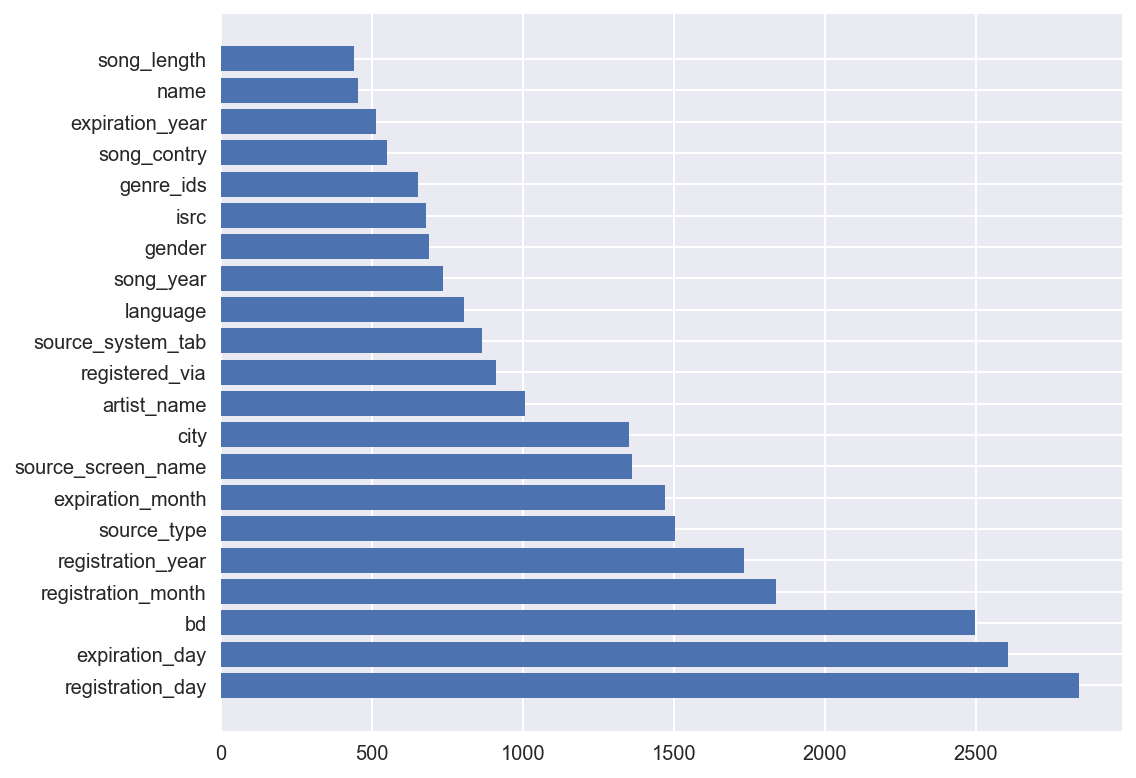

In [39]:
plot_feature_importance(model)

In [40]:
model = train_lgb(X_train_transformed.drop(["song_length", "expiration_year", "name"], axis=1),
                  X_val_transformed.drop(["song_length", "expiration_year", "name"], axis=1),
                  y_train, y_val, best_params)

[50]	training's auc: 0.724042	valid_1's auc: 0.723527
[100]	training's auc: 0.740027	valid_1's auc: 0.737488


Качество осталось на прежнем уровне, зато используем меньше фичей.

## SHAP

Пробовал делать `SHAP`, ноуту было тяжело, отказался от этой идеи.

## K-Fold evaluation

In [41]:
def k_fold_evaluation(X: pd.DataFrame, y: pd.DataFrame, params,
                      k: int = 5, split_type: str = "simple"):
    skf = StratifiedKFold(n_splits=k, shuffle=True)
    kf = KFold(n_splits=k)
    
    if split_type == "simple":
        split = kf.split(X)
    elif split_type == "by_y":
        split = skf.split(X, y)
    elif split_type == "by_user":
        split = skf.split(X, train['msno'])
    else:
        raise ValueError
        
    start, end = '\033[92m', '\033[0m'
        
    roc_aucs = []
    for i, (train_index, test_index) in enumerate(split):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,
                                                           random_state=1)
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        
        lgb_train = lgb.Dataset(X_train, y_train, params={'verbose': -1})
        lgb_val = lgb.Dataset(X_val, y_val, params={'verbose': -1})

        model = lgb.train(params, 
                          train_set=lgb_train, 
                          num_boost_round=100, 
                          verbose_eval=-1,
                          valid_sets=[lgb_train, lgb_val])
        
        roc_auc = roc_auc_score(y_test, model.predict(X_test))
        
        print(f"Fold {i + 1:>2}, ROC-AUC: {round(roc_auc, 5)}")
        roc_aucs.append(roc_auc)
        
    print(f"{start}Mean AUC_ROC: {np.mean(roc_aucs):.3f} with {k} folds{end}")

In [42]:
X_train_transformed = catboost_encoder.fit_transform(X, y)

Попробуем разные разбиения.

In [43]:
k_fold_evaluation(X_train_transformed, y, best_params)

Fold  1, ROC-AUC: 0.74443
Fold  2, ROC-AUC: 0.71417
Fold  3, ROC-AUC: 0.69312
Fold  4, ROC-AUC: 0.67791
Fold  5, ROC-AUC: 0.65456
Mean AUC_ROC: 0.697 with 5 folds


In [44]:
k_fold_evaluation(X_train_transformed, y, best_params, split_type="by_y")

Fold  1, ROC-AUC: 0.74969
Fold  2, ROC-AUC: 0.7494
Fold  3, ROC-AUC: 0.7497
Fold  4, ROC-AUC: 0.75038
Fold  5, ROC-AUC: 0.74962
Mean AUC_ROC: 0.750 with 5 folds


In [45]:
k_fold_evaluation(X_train_transformed, y, best_params, split_type="by_user")

Fold  1, ROC-AUC: 0.7498
Fold  2, ROC-AUC: 0.75054
Fold  3, ROC-AUC: 0.74937
Fold  4, ROC-AUC: 0.74951
Fold  5, ROC-AUC: 0.75095
Mean AUC_ROC: 0.750 with 5 folds


# Построение эмбеддингов

In [46]:
train = pd.read_csv(os.path.join(data_path, "train.csv"))
songs = pd.read_csv(os.path.join(data_path, "songs.csv"))
song_extra_info = pd.read_csv(os.path.join(data_path, "song_extra_info.csv"))

In [47]:
train = train.loc[:, ["msno", "song_id", "target"]]

In [48]:
songs = songs.merge(song_extra_info, on="song_id", how="left")

In [49]:
def join_names(x):
    return str(x["artist_name"]) + ' ' + str(x["name"])


songs["artist_song"] = songs[["artist_name", "name"]].apply(lambda x: join_names(x), axis=1)
songs = songs.loc[:, ["song_id", "artist_song"]]

In [50]:
train = train.merge(songs, on="song_id", how="left")
train_cache = deepcopy(train)

Рассмотрим те песни, которые слушали.

In [51]:
mask = train["target"] == 1
train = train.loc[mask, ["msno", "artist_song"]]

Если не сделать такую магию кодирования, то на построение корпуса уйдет больше часа. 

In [52]:
users = {user: i for i, user in enumerate(train["msno"].unique())}
songs = {song: j for j, song in enumerate(train["artist_song"].unique())}

train["msno"] = train["msno"].apply(lambda x: users[x])
train["artist_song"] = train["artist_song"].apply(lambda x: songs[x])

In [53]:
X = train.to_numpy()
corpus = [[str(x) for x in X[X[:, 0] == user][:, 1]] for user in tqdm(train["msno"].unique())]

100%|██████████| 27113/27113 [04:16<00:00, 105.86it/s]


Обучим `Word2Vec`.

In [54]:
model = Word2Vec(window=10,
                 vector_size=128,
                 negative=20,
                 min_count=1,
                 sg=0,
                 workers = multiprocessing.cpu_count())

model.build_vocab(corpus)

In [55]:
%%time
model.train(corpus, total_examples=model.corpus_count, epochs=100, report_delay=1)

CPU times: user 59min 11s, sys: 16.3 s, total: 59min 27s
Wall time: 8min 35s


(371305030, 371465600)

In [56]:
songs_inversed = {j: i for i, j in songs.items()}

def get_similars(code: str, num: int = 5):
    for sim in model.wv.most_similar(code)[:num]:
        print(f"Score: {sim[1]:.2f}, {songs_inversed[int(sim[0])]}")

Посмотрим на `Eminem`.

In [63]:
songs['Eminem The Kids']

78824

In [64]:
get_similars("78824")

Score: 0.72, Eminem Amityville
Score: 0.72, Eminem Public Service Announcement 2000
Score: 0.70, Eminem Kim
Score: 0.69, Eminem Bitch Please II
Score: 0.69, TV & MOVIE SOUNDTRAX Big Girls Don't Cry (From "Mermaids")


Построим эмбеддинги для пользователей. Просто берем среднее по всем песням, которые слушал пользователь.

In [65]:
user_embedings = {}
for user, i in enumerate(train.msno.unique()):
    user_embedings[user] = np.array([model.wv[str(i)] for i in corpus[i]]).mean(axis=0)

В качестве нового признака добавим скоры от эмбеддингов.

In [66]:
scores = []

for row in train_cache.loc[:, ['msno', 'artist_song']].to_numpy():
    user, song = row
    score = 0
    
    if user in users and song in songs and users[user] in user_embedings and songs[song] in model.wv:
        score = np.sum(user_embedings[users[user]] * model.wv[songs[song]])
    
    scores.append(score)

In [67]:
train_cache["scores"] = scores

In [68]:
train = pd.read_csv('part_1.csv')
X, y = train.drop(columns=['target']), train['target']

X_train_transformed = catboost_encoder.fit_transform(X, y)

part_2 = pd.merge(X_train_transformed, train_cache.drop(["target", "artist_song"], axis=1),
                  how="left", left_on=['msno', 'song_id'], right_on = ['msno', 'song_id'])

X = part_2.drop(['msno', 'song_id'], axis=1)

In [69]:
k_fold_evaluation(X, y, best_params, split_type="by_user")

Fold  1, ROC-AUC: 0.76193
Fold  2, ROC-AUC: 0.76209
Fold  3, ROC-AUC: 0.76175
Fold  4, ROC-AUC: 0.76289
Fold  5, ROC-AUC: 0.76328
Mean AUC_ROC: 0.762 with 5 folds


Добавление новых фичей помогло улучшить качество.